#**Load the dataset**

In [3]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Statistics_Final_Project_Kakep/webtraffic.csv', index_col=0)
print(df.shape)
df.head()

(4896, 1)


,Sessions
Hour Index,
0,1418159421
1,1113769116
2,919158921
3,822352824
4,735526737


In [5]:
# Define the starting datetime
start_datetime = "2025-01-01 00:00:00"

# Generate a datetime index for the hours
df['Datetime'] = pd.date_range(start=start_datetime, periods=len(df), freq='h')

# Set the datetime column as the index
df.set_index('Datetime', inplace=True)

time_series = df['Sessions']

print(time_series)

Datetime
2025-01-01 00:00:00    1418159421
2025-01-01 01:00:00    1113769116
2025-01-01 02:00:00     919158921
2025-01-01 03:00:00     822352824
2025-01-01 04:00:00     735526737
                          ...    
2025-07-23 19:00:00    2555880561
2025-07-23 20:00:00    2454084459
2025-07-23 21:00:00    2405182410
2025-07-23 22:00:00    2356280361
2025-07-23 23:00:00    1987019991
Name: Sessions, Length: 4896, dtype: int64


# **Split data to train/test**

In [6]:
data = time_series.values

split_index = int(len(data)  - 24)

train_data = data[:split_index]
test_data = data[split_index:]

train_time_series = pd.Series(train_data, index=time_series.index[:split_index])
test_time_series = pd.Series(test_data, index=time_series.index[split_index:])

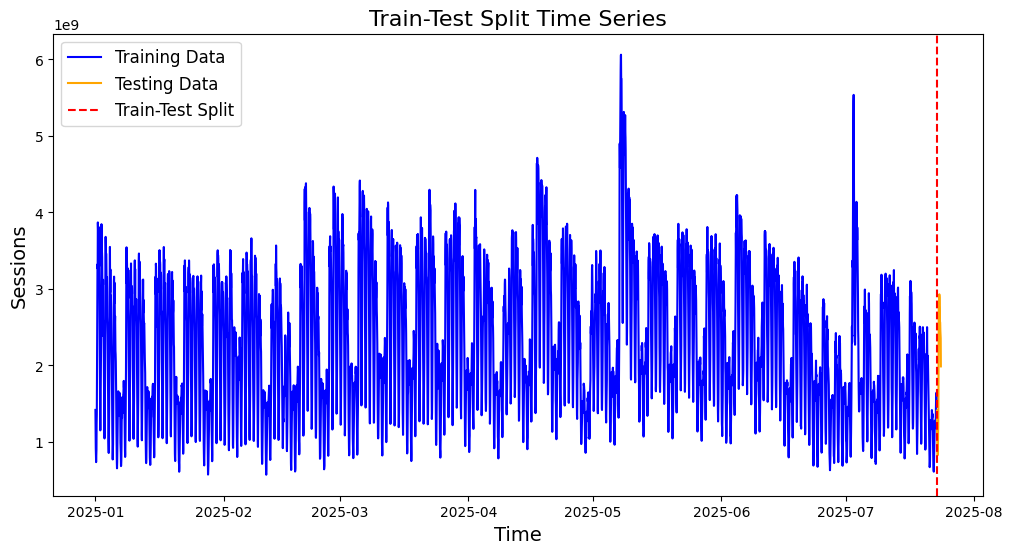

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_time_series, label="Training Data", color="blue")
plt.plot(test_time_series, label="Testing Data", color="orange")
plt.axvline(x=test_time_series.index[0], color="red", linestyle="--", label="Train-Test Split")
plt.title("Train-Test Split Time Series", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Sessions", fontsize=14)
plt.legend(fontsize=12)
plt.show()


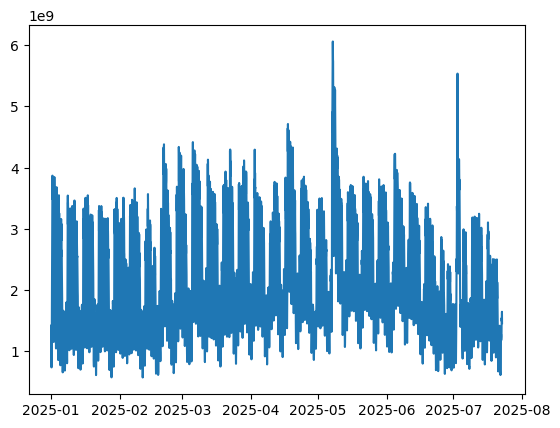

In [8]:
plt.plot(train_time_series)

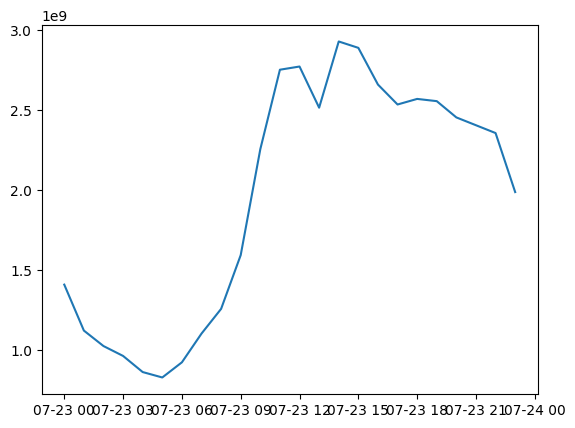

In [35]:
plt.plot(test_time_series)

# **Check stationarity**

In [9]:
from statsmodels.tsa.stattools import kpss

def perform_kpss_test(ts, significance_level=0.05):
    try:
        kpss_stat, p_value, critical_values, _ = kpss(ts, regression='c', nlags='auto')
        is_stationary = p_value > significance_level

        print("KPSS Test Statistic:", kpss_stat)
        print("p-value:", p_value)
        print("Critical Values:", critical_values)
        print(f"The series is {'stationary' if is_stationary else 'NOT stationary'}")

        return {
            "KPSS Test Statistic": kpss_stat,
            "p-value": p_value,
            "Critical Values": critical_values,
            "Stationary": is_stationary
        }
    except Exception as e:
        print(f"Error in KPSS test: {e}")
        return None


In [10]:
!pip install --upgrade statsmodels

In [11]:
from IPython.display import display
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from time import time
import seaborn as sns

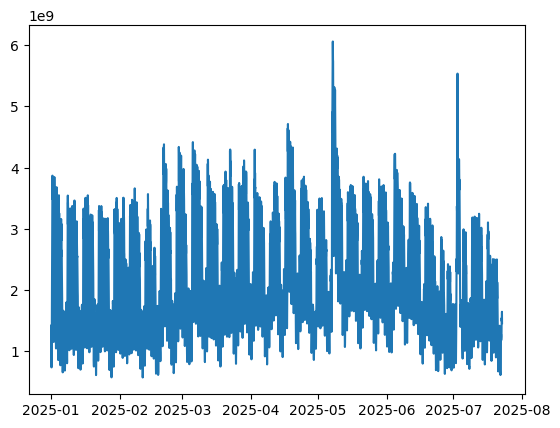

In [12]:
from sklearn.model_selection import train_test_split

plt.plot(train_time_series)
plt.show()

# **Seasonal Decomposition And Manual Differencing**

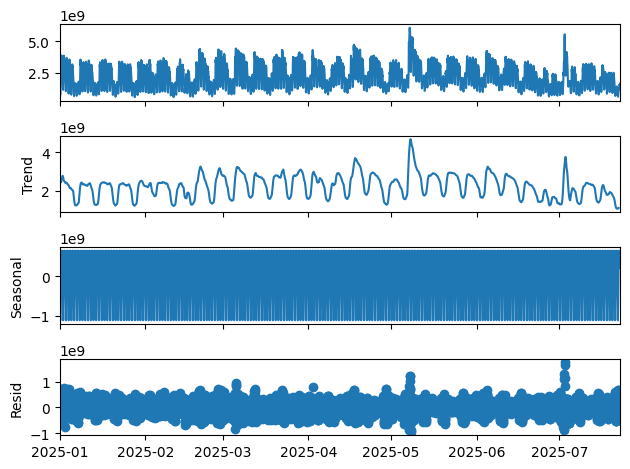

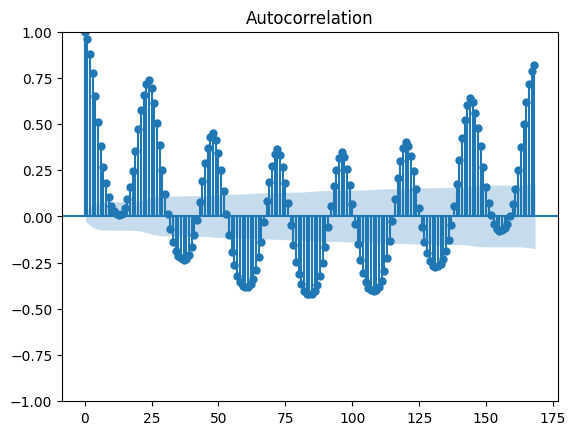

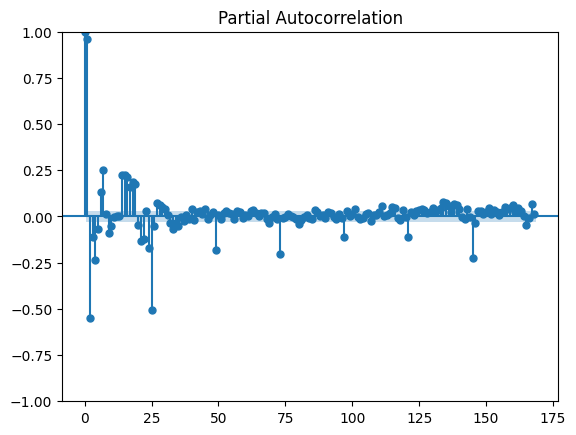

In [13]:
result = seasonal_decompose(train_time_series, model='additive')
result.plot()
plt.show()

plot_acf(train_time_series, lags=7 * 24)
plt.show()
plot_pacf(train_time_series, lags= 7 * 24)
plt.show()

In [14]:
import numpy as np
from scipy.fft import fft

fft_result = fft(train_time_series)
frequencies = np.fft.fftfreq(len(train_time_series))

dominant_freq = frequencies[np.argmax(np.abs(fft_result[1:])) + 1]
seasonal_period = int(1 / dominant_freq)
print(f"Detected Seasonal Period: {seasonal_period}")

Detected Seasonal Period: 24


In [15]:
perform_kpss_test(train_time_series)

KPSS Test Statistic: 0.5149066318236103
p-value: 0.03830931715684453
Critical Values: 37
The series is NOT stationary


{'KPSS Test Statistic': 0.5149066318236103,
 'p-value': 0.03830931715684453,
 'Critical Values': 37,
 'Stationary': False}

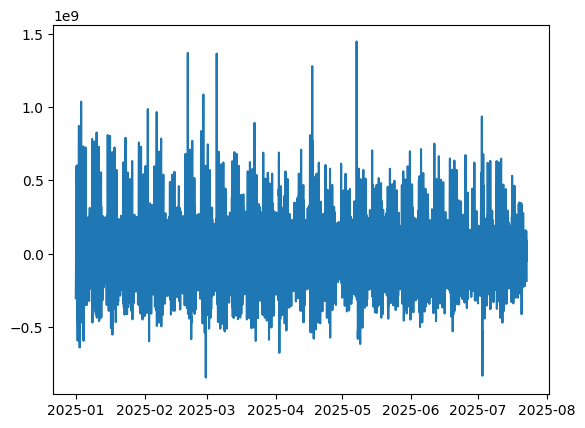

In [16]:
time_series_differenced = train_time_series.diff().dropna()
plt.plot(time_series_differenced)
plt.show()

In [17]:
perform_kpss_test(time_series_differenced)

KPSS Test Statistic: 0.002099556229044641
p-value: 0.1
Critical Values: 10
The series is stationary


<ipython-input-9-41fdbdbf8812>:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, critical_values, _ = kpss(ts, regression='c', nlags='auto')


{'KPSS Test Statistic': 0.002099556229044641,
 'p-value': 0.1,
 'Critical Values': 10,
 'Stationary': True}

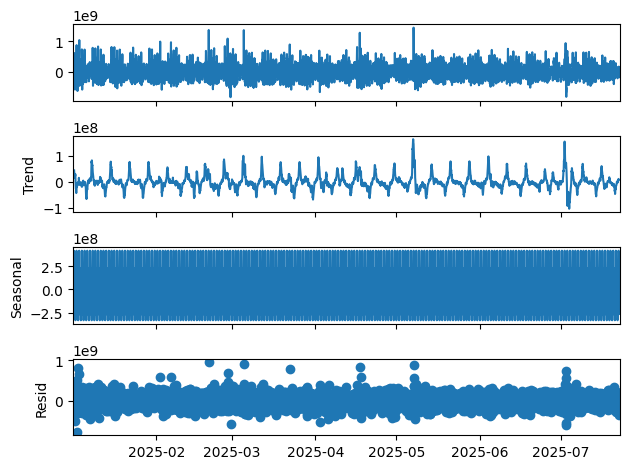

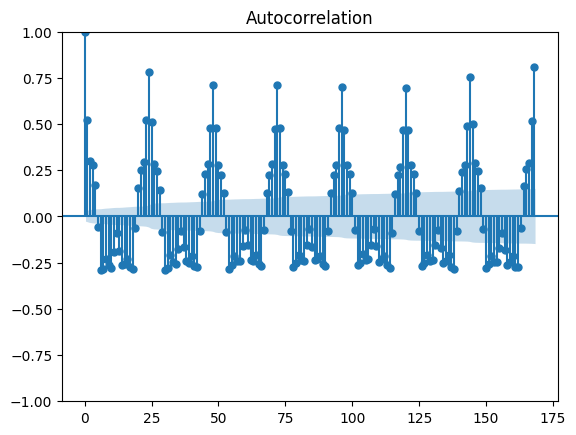

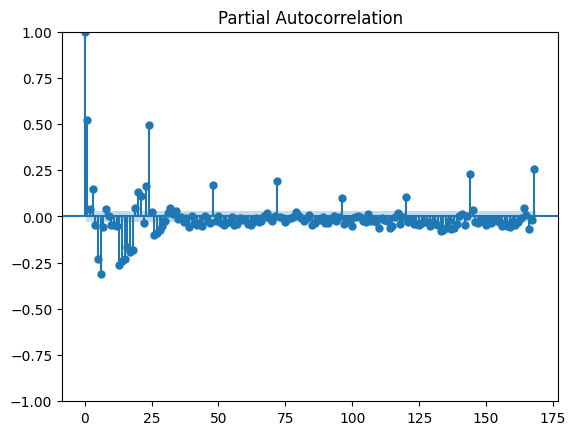

In [18]:
result = seasonal_decompose(time_series_differenced, model='additive')
result.plot()
plt.show()

plot_acf(time_series_differenced, lags=7 * 24)
plt.show()
plot_pacf(time_series_differenced, lags= 7 * 24)
plt.show()

In [19]:
pip install --upgrade matplotlib


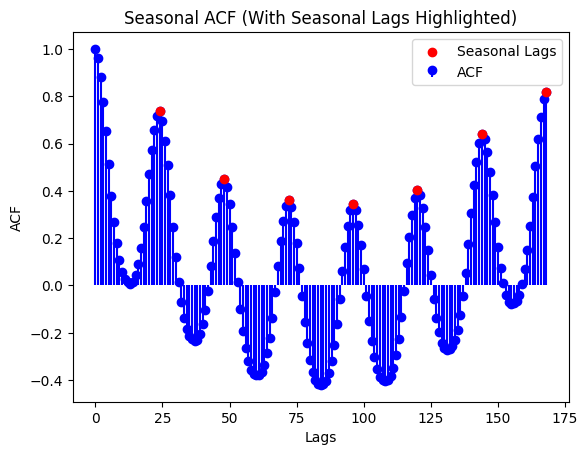

In [20]:
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

# Define the seasonal period (e.g., s=24 for hourly data with daily seasonality)
seasonal_period = 24

# Compute ACF values
acf_values = acf(train_time_series, nlags=seasonal_period * 7)

# Create a range of lags
lags = range(len(acf_values))

# Plot the ACF (default stem plot)
plt.stem(lags, acf_values, basefmt=" ", label='ACF', linefmt='b-', markerfmt='bo')

# Highlight seasonal lags with a scatter plot
seasonal_lags = range(seasonal_period, len(acf_values), seasonal_period)
plt.scatter(seasonal_lags, [acf_values[lag] for lag in seasonal_lags], color='red', label='Seasonal Lags', zorder=3)

# Add labels and title
plt.title('Seasonal ACF (With Seasonal Lags Highlighted)')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.legend()
plt.show()


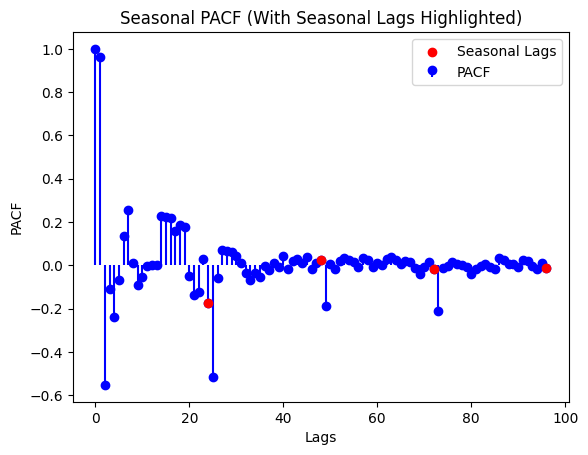

In [21]:
from statsmodels.tsa.stattools import pacf
import matplotlib.pyplot as plt

# Define the seasonal period (e.g., s=24 for hourly data with daily seasonality)
seasonal_period = 24

# Compute PACF values
pacf_values = pacf(train_time_series, nlags=seasonal_period * 4)

# Create a range of lags
lags = range(len(pacf_values))

# Plot the PACF (default stem plot)
plt.stem(lags, pacf_values, basefmt=" ", label='PACF', linefmt='b-', markerfmt='bo')

# Highlight seasonal lags with a scatter plot
seasonal_lags = range(seasonal_period, len(pacf_values), seasonal_period)
plt.scatter(seasonal_lags, [pacf_values[lag] for lag in seasonal_lags], color='red', label='Seasonal Lags', zorder=3)

# Add labels and title
plt.title('Seasonal PACF (With Seasonal Lags Highlighted)')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.legend()
plt.show()



Datetime
2025-01-02 00:00:00    1.114767e+09
2025-01-02 01:00:00    1.003989e+09
2025-01-02 02:00:00    8.562849e+08
2025-01-02 03:00:00    5.738506e+08
2025-01-02 04:00:00    4.151684e+08
dtype: float64


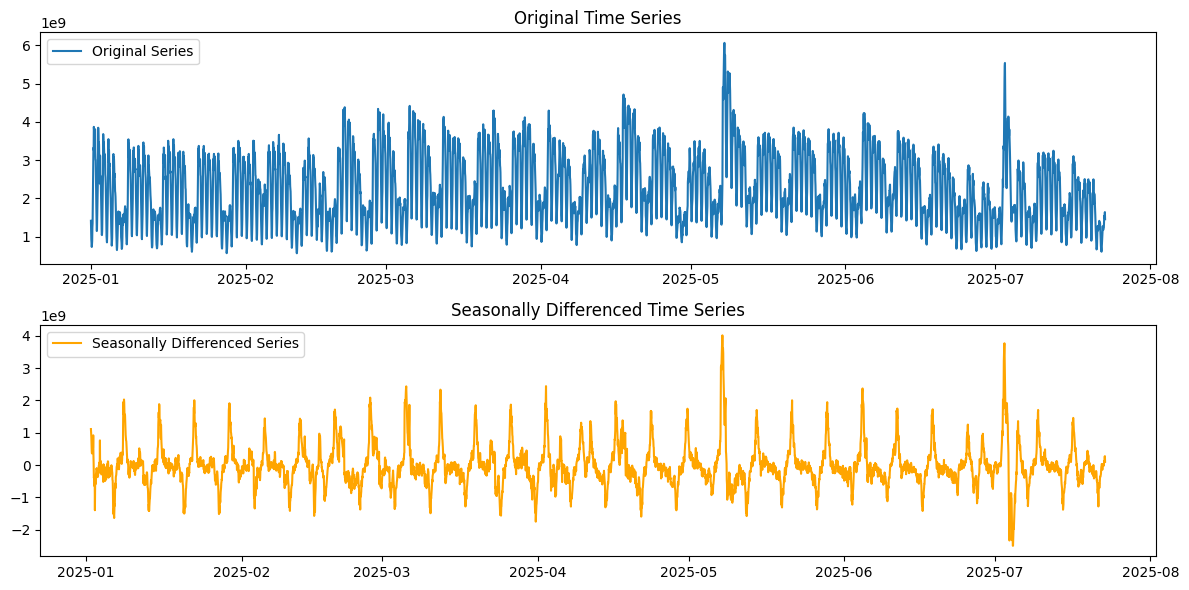

In [22]:
import pandas as pd
seasonal_period = 24

seasonally_differenced = train_time_series.diff(seasonal_period)

seasonally_differenced = seasonally_differenced.dropna()

print(seasonally_differenced.head())

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(train_time_series, label="Original Series")
plt.title("Original Time Series")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(seasonally_differenced, label="Seasonally Differenced Series", color="orange")
plt.title("Seasonally Differenced Time Series")
plt.legend()

plt.tight_layout()
plt.show()


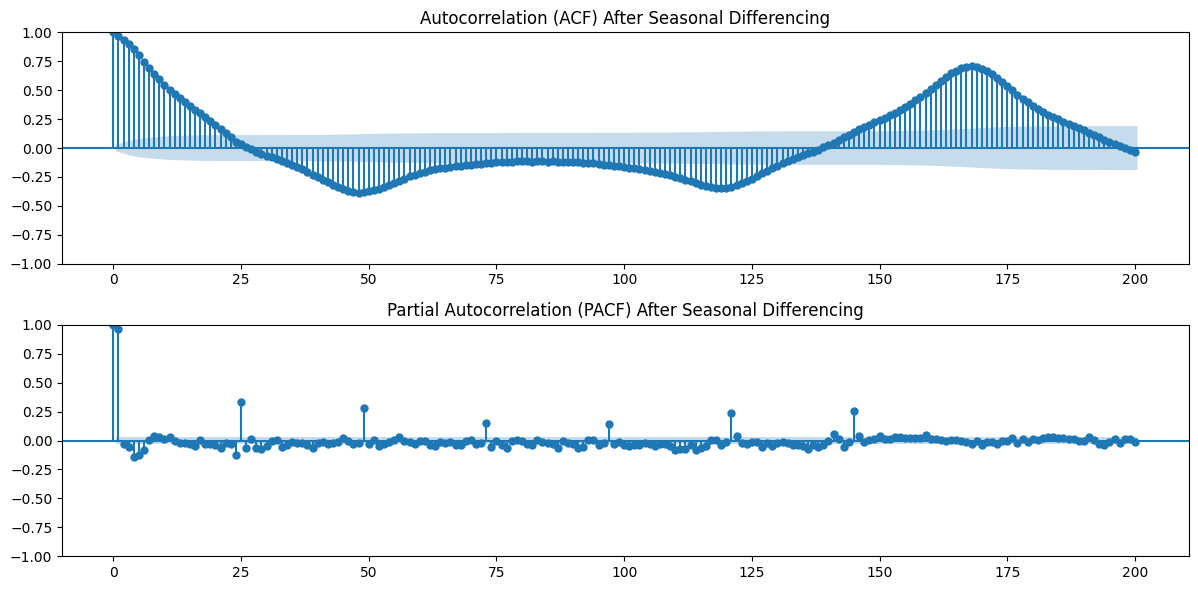

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

seasonal_period = 24

seasonally_differenced = train_time_series.diff(seasonal_period)

seasonally_differenced = seasonally_differenced.dropna()

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plot_acf(seasonally_differenced, lags=200, ax=plt.gca())
plt.title("Autocorrelation (ACF) After Seasonal Differencing")

plt.subplot(2, 1, 2)
plot_pacf(seasonally_differenced, lags=200, ax=plt.gca(), method="ywm")
plt.title("Partial Autocorrelation (PACF) After Seasonal Differencing")

plt.tight_layout()
plt.show()


#**Train SARIMA model**

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

sarima_model = SARIMAX(
    train_time_series,
    order=(1, 1, 1),
    seasonal_order=(2, 1, 1, 24)
)
sarima_fit = sarima_model.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


#**Forecast SARIMA model**

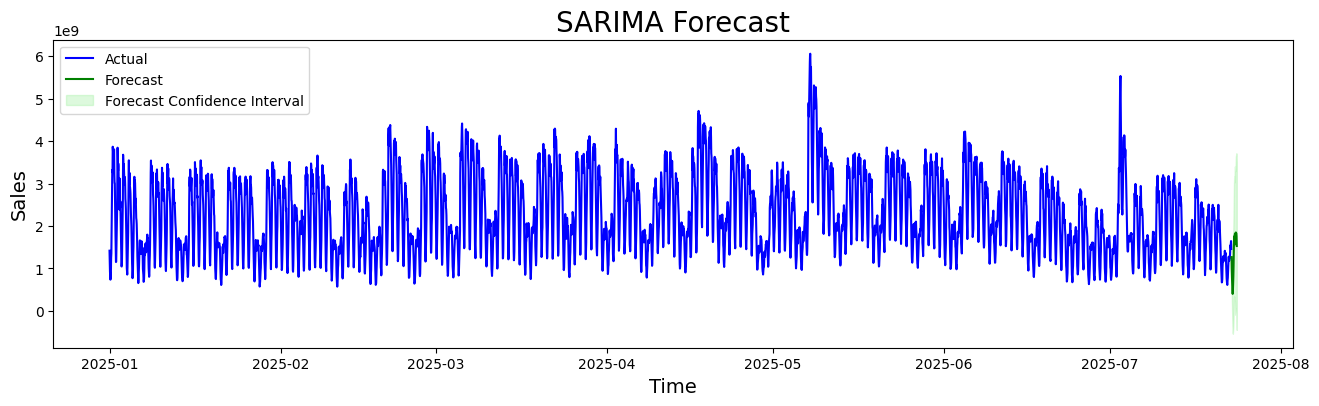

In [25]:
forecast_steps = 24
forecast = sarima_fit.get_forecast(steps=forecast_steps)

# Extract forecasted mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Create an index for the forecasted steps
forecast_index = pd.date_range(start=train_time_series.index[-1], periods=forecast_steps + 1, freq="h")[1:]

# Visualize forecast
plt.figure(figsize=(16, 4))
plt.plot(train_time_series, label="Actual", color="blue")
plt.plot(forecast_index, forecast_mean, label="Forecast", color="green")
plt.fill_between(
    forecast_index,
    forecast_conf_int.iloc[:, 0],
    forecast_conf_int.iloc[:, 1],
    color="lightgreen",
    alpha=0.3,
    label="Forecast Confidence Interval"
)
plt.title("SARIMA Forecast", fontsize=20)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Sales", fontsize=14)
plt.legend()
plt.show()


#**Evaluate SARIMA model**

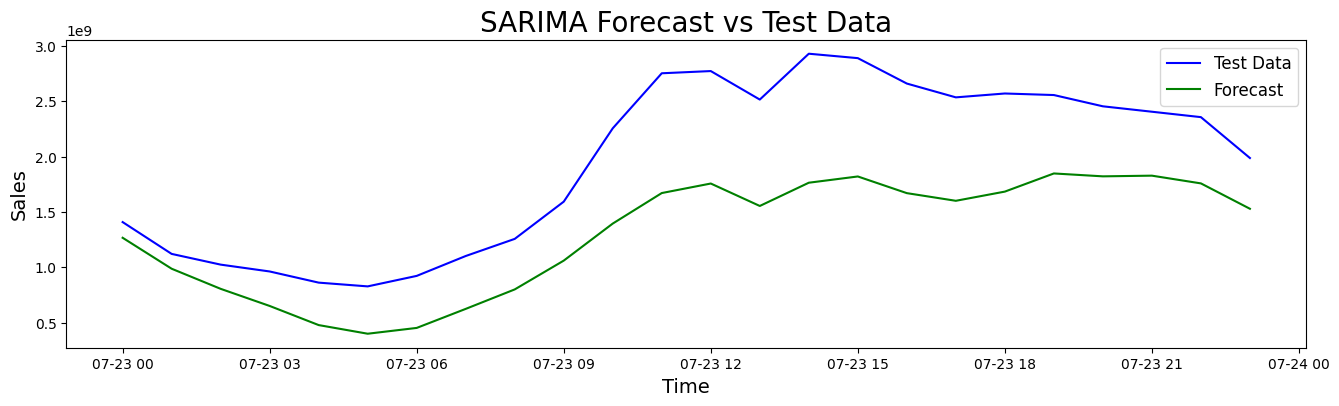

In [26]:
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

forecast_index = pd.date_range(start=train_time_series.index[-1], periods=forecast_steps + 1, freq="h")[1:]

test_time_series_limited = test_time_series.iloc[:forecast_steps]

plt.figure(figsize=(16, 4))
plt.plot(test_time_series_limited, label="Test Data", color="blue")
plt.plot(forecast_index, forecast_mean, label="Forecast", color="green")
plt.title("SARIMA Forecast vs Test Data", fontsize=20)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Sales", fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

forecasted_values = forecast_mean[:len(test_time_series_limited)]
actual_values = test_time_series_limited

mae = mean_absolute_error(actual_values, forecasted_values)
mse = mean_squared_error(actual_values, forecasted_values)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_values - forecasted_values) / actual_values)) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Error (MAE): 645585993.66
Mean Squared Error (MSE): 511020642046580224.00
Root Mean Squared Error (RMSE): 714857078.06
Mean Absolute Percentage Error (MAPE): 33.32%


In [28]:
# Display AIC and BIC
print(f"AIC: {sarima_fit.aic}")
print(f"BIC: {sarima_fit.bic}")

AIC: 195258.24813738454
BIC: 195297.1648287996


#**Train ARIMA model**

In [29]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd


In [30]:
arima_model = ARIMA(train_time_series, order=(5, 1, 2))
arima_fit = arima_model.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

#**Forecast ARIMA model**

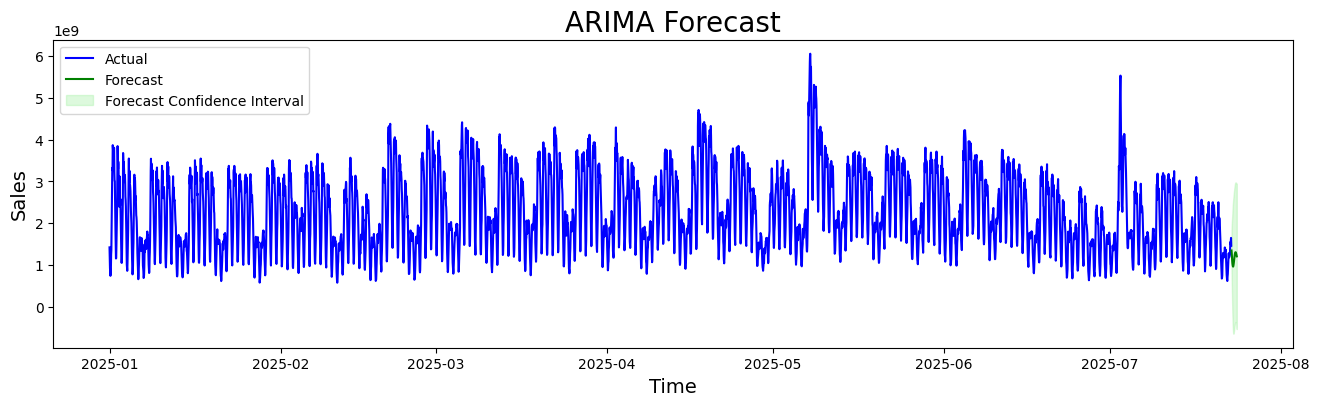

In [31]:
forecast_steps = 24
forecast = arima_fit.get_forecast(steps=forecast_steps)

forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

forecast_index = pd.date_range(start=train_time_series.index[-1], periods=forecast_steps + 1, freq="h")[1:]

plt.figure(figsize=(16, 4))
plt.plot(train_time_series, label="Actual", color="blue")
plt.plot(forecast_index, forecast_mean, label="Forecast", color="green")
plt.fill_between(
    forecast_index,
    forecast_conf_int.iloc[:, 0],
    forecast_conf_int.iloc[:, 1],
    color="lightgreen",
    alpha=0.3,
    label="Forecast Confidence Interval"
)
plt.title("ARIMA Forecast", fontsize=20)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Sales", fontsize=14)
plt.legend()
plt.show()


#**Evaluate ARIMA model**

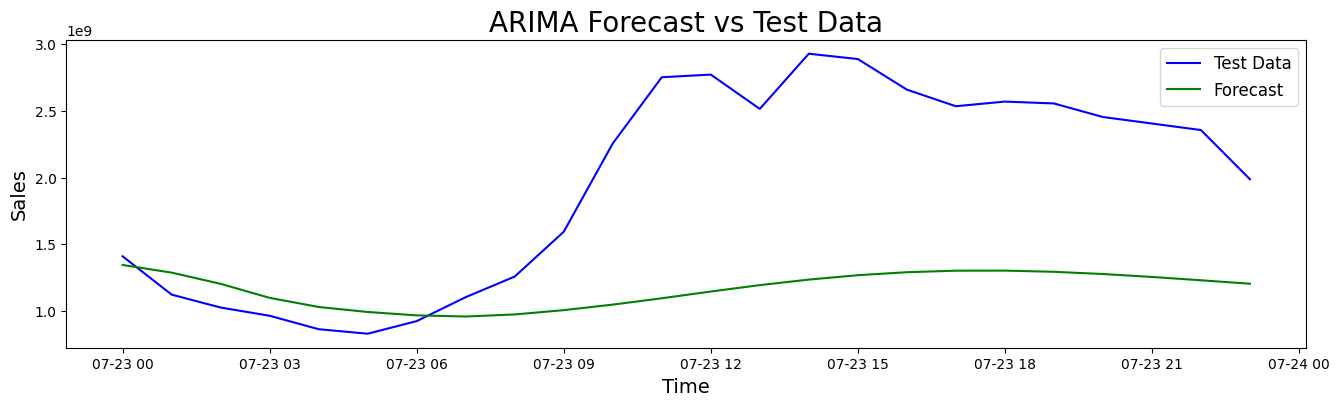

In [32]:
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

forecast_index = pd.date_range(start=train_time_series.index[-1], periods=forecast_steps + 1, freq="h")[1:]

test_time_series_limited = test_time_series.iloc[:forecast_steps]

plt.figure(figsize=(16, 4))
plt.plot(test_time_series_limited, label="Test Data", color="blue")
plt.plot(forecast_index, forecast_mean, label="Forecast", color="green")
plt.title("ARIMA Forecast vs Test Data", fontsize=20)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Sales", fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

forecasted_values = forecast_mean[:len(test_time_series_limited)]
actual_values = test_time_series_limited

mae = mean_absolute_error(actual_values, forecasted_values)
mse = mean_squared_error(actual_values, forecasted_values)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_values - forecasted_values) / actual_values)) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 852131270.34
Mean Squared Error (MSE): 1080088374117524992.00
Root Mean Squared Error (RMSE): 1039273002.69
Mean Absolute Percentage Error (MAPE): 37.03%


In [34]:
# Display AIC and BIC
print(f"AIC: {arima_fit.aic}")
print(f"BIC: {arima_fit.bic}")

AIC: 199942.12008139968
BIC: 199994.04851767013
